In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Loading of action logs : retweets

In [3]:
action_log = pd.read_pickle("data/df_retweets_filtered.pkl")

In [4]:
action_log.sort_values(by='Date').head(5)

,RT,Date,User1,User2,Orig,nRtOrig,weightEdge
0,5483194148,2009-11-06 17:59:58,45270050,62581962,5427015317,106,1
1,5507323285,2009-11-07 15:51:23,26190403,62581962,5427015317,106,5
212,5524130451,2009-11-08 05:25:48,14540380,813286,5523912708,8,1
213,5524312752,2009-11-08 05:34:11,24140119,813286,5523912708,8,1
214,5527425338,2009-11-08 08:36:40,16070416,813286,5523912708,8,1


In [5]:
children = action_log.groupby('User2').agg({'User1' : list})
parents = action_log.groupby('User1').agg({'User2' : list})

In [6]:
"""
Au.loc[User1] = # of retweets done by User1
Av2u.loc[[(User2, User1)]] = # of retweets done by User1 about User2's tweets
Av[User2] = # of retweets about user2's tweets
cred.loc[User1] = credit of User1
                = 1 / number of different User2 User1 retweeted
"""
Au = action_log.groupby('User1').RT.count()
Av = action_log.groupby('User2').RT.count()

Av2u = action_log.groupby(by=['User1', 'User2']).RT.count().reset_index()
Av2u.index = zip(Av2u['User2'], Av2u['User1'])
Av2u = Av2u.drop(columns=['User1', 'User2'])

cred = action_log.groupby('User1').agg({'User2' : set})
cred.reset_index(inplace = True)
cred['d'] = cred.User2.apply(lambda x : 1/len(x) )
cred.index = cred['User1']
cred.drop(columns=['User1', 'User2'], inplace = True)

Distribution of Au, Av, Av2u, cred

Text(0.5, 1.0, 'credit per target')

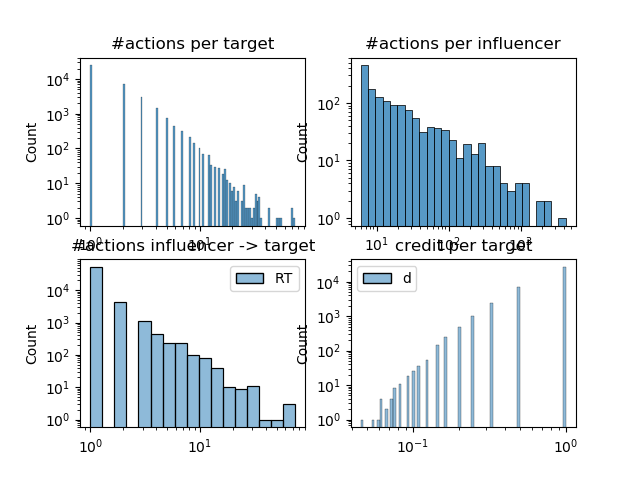

In [7]:
%matplotlib widget
fig, axes = plt.subplots(2,2)

sns.histplot(Au, log_scale=True, ax = axes[0,0], ) 
sns.histplot(Av, log_scale=True, ax = axes[0,1]) 
sns.histplot(Av2u, log_scale=True, ax = axes[1,0]) 
sns.histplot(cred, log_scale=True, ax = axes[1,1]) 

axes[0,0].set_yscale('log')
axes[0,0].set_title('#actions per target')

axes[0,1].set_yscale('log')
axes[0,1].set_title('#actions per influencer')

axes[1,0].set_yscale('log')
axes[1,0].set_title('#actions influencer -> target')

axes[1,1].set_yscale('log')
axes[1,1].set_title('credit per target')



Computation of $p_{uv}$

In [8]:

def p(u,v, mode='BT', with_cred = False) :
    """
    returns estimation of p_uv with credits
    BT : a(v->u) / a(u)
    JI : a(v->u) / (a(u) + a(v))
    LP : a(v->u) / a(v)
    
    try with : handles the case if u, v or (u,v) are not in the tables : no link
    """
    try :
        c = 1
        if with_cred : 
            c = float(cred.loc[u])
        
        if mode == 'BT':
            return c * float(Av2u.loc[[(v, u)]].RT) / float(Au.loc[u])
        elif mode == 'JI' :
            return c * float(Av2u.loc[[(v, u)]].RT) / (float(Au.loc[u]) + float(Av.loc[v]))
        elif mode == 'LP' :
            return c * float(Av2u.loc[[(v, u)]].RT) / float(Av.loc[v])
        
    except : 
        return 0




In [9]:
%%time
edges_BT = pd.Series(Av2u.index, index=Av2u.index).apply(lambda x : p(x[1], x[0], mode='BT'))
edges_JI = pd.Series(Av2u.index, index=Av2u.index).apply(lambda x : p(x[1], x[0], mode='JI'))
edges_LP = pd.Series(Av2u.index, index=Av2u.index).apply(lambda x : p(x[1], x[0], mode='LP'))
edges_BTC = pd.Series(Av2u.index, index=Av2u.index).apply(lambda x : p(x[1], x[0], mode='BT', with_cred=True))

CPU times: total: 2min 8s
Wall time: 2min 8s


Distribution of $p_{uv}$

Text(0.5, 1.0, 'edges_BTC')

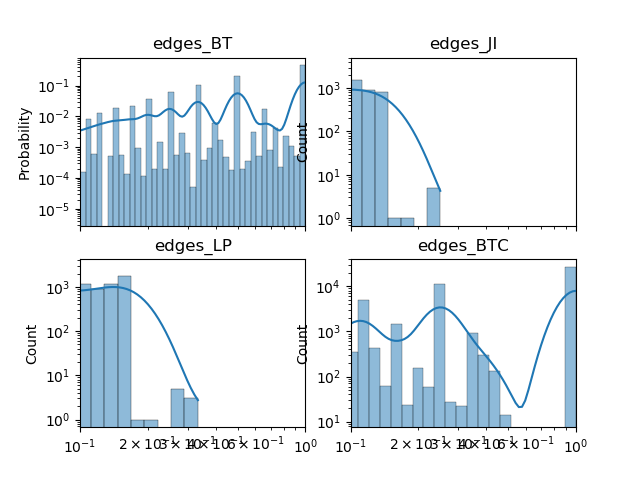

In [10]:
%matplotlib widget
fig, axes = plt.subplots(2,2, sharex=True)

sns.histplot(edges_BT, log_scale=True, ax = axes[0,0], kde = True, stat = 'probability') 
sns.histplot(edges_JI, log_scale=True, ax = axes[0,1], kde = True) 
sns.histplot(edges_LP, log_scale=True, ax = axes[1,0], kde = True) 
sns.histplot(edges_BTC, log_scale=True, ax = axes[1,1], kde = True) 

axes[0,0].set_yscale('log')
axes[0,0].set_title('edges_BT')
plt.xlim(0.1,1)
axes[0,1].set_yscale('log')
axes[0,1].set_title('edges_JI')

axes[1,0].set_yscale('log')
axes[1,0].set_title('edges_LP')

axes[1,1].set_yscale('log')
axes[1,1].set_title('edges_BTC')


In [1]:
edges_BT

NameError: name 'edges_BT' is not defined